### segment waveform into individual syllables using dynamic thresholding
- 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
import pandas as pd
from datetime import datetime

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import warnings
warnings.filterwarnings(action='once')

In [4]:
from avgn.utils.audio import load_wav, read_wav
from avgn.signalprocessing.filtering import butter_bandpass_filter
from vocalseg.dynamic_thresholding import dynamic_threshold_segmentation
from vocalseg.dynamic_thresholding import plot_segmented_spec, plot_segmentations

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [5]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [6]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [7]:
DATASET_ID = 'insect_dataset_cricket'

### Load data in original format

In [8]:
# create a unique datetime identifier for the files output by this notebook
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

'2019-10-08_11-56-59'

### create dataset

In [9]:
hparams = HParams(
    n_fft = 4096,
    mel_lower_edge_hertz=50,
    mel_upper_edge_hertz=20000,
    butter_lowcut = 500,
    butter_highcut = 20000,
    ref_level_db = 20,
    min_level_db = -100,
    win_length_ms = 4,
    hop_length_ms = 1,
    n_jobs = -1,
    verbosity=1,
    nex = -1
)

In [10]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/avgn/utils/json.py:64: ResourceWarning: unclosed file <_io.TextIOWrapper name='/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/processed/insect_dataset_cricket/2019-06-26_16-00-45/JSON/CR_kinhibari.JSON' mode='r' encoding='UTF-8'>
  return json.load(open(json_loc), object_pairs_hook=OrderedDict)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   10.6s finished


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:5605: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/AD/tsainbur/.keras/keras.json' mode='r' encoding='UTF-8'>
  _config = json.load(open(_config_path))
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/ops/signal/util_ops.py:62: DeprecationWarning: fractions.gcd() is deprecated. Use math.gcd() instead.
  return ops.convert_to_tensor(fractions.gcd(const_a, const_b))


In [11]:
dataset.sample_json

OrderedDict([('species_id', 'kinhibari'),
             ('species', 'Gryllidae sp.'),
             ('common_name', 'cricket'),
             ('wav_loc', '/mnt/cube/Datasets/insectORIG/CR_kinhibari.wav'),
             ('samplerate_hz', 44100),
             ('length_s', 20.45387755102041),
             ('indvs', OrderedDict([('kinhibari', OrderedDict())]))])

In [12]:
### segmentation parameters
n_fft=1024
hop_length_ms=1
win_length_ms=3
ref_level_db=20
pre=0.97
min_level_db=-40
min_level_db_floor = -5
db_delta = 5
silence_threshold = 0.25
min_silence_for_spec=0.15
max_vocal_for_spec=0.05,
min_syllable_length_s = 0.0025,
butter_min = 500
butter_max = 15000
spectral_range = [500, 15000]

In [13]:
import librosa

In [14]:
rate, data = load_wav(dataset.sample_json["wav_loc"])

In [15]:
data = data#[:rate*15]

In [16]:
np.min(data), np.max(data)

(-0.24513245, 0.32736206)

In [17]:
data = data / np.max(np.abs(data))

In [18]:
# filter data
data = butter_bandpass_filter(data, butter_min, butter_max, rate)

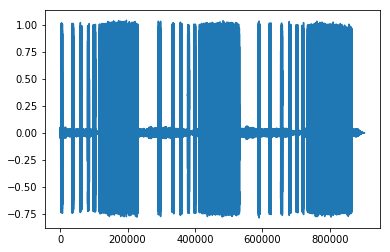

In [19]:
plt.plot(data)

In [20]:
# segment
results = dynamic_threshold_segmentation(
    data,
    rate,
    n_fft=n_fft,
    hop_length_ms=hop_length_ms,
    win_length_ms=win_length_ms,
    min_level_db_floor=min_level_db_floor,
    db_delta=db_delta,
    ref_level_db=ref_level_db,
    pre=pre,
    min_silence_for_spec=min_silence_for_spec,
    max_vocal_for_spec=max_vocal_for_spec,
    min_level_db=min_level_db,
    silence_threshold=silence_threshold,
    verbose=True,
    min_syllable_length_s=min_syllable_length_s,
    spectral_range=spectral_range,
)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


longest silence 1.3550000000000004
longest vocalization 0.031000000000000583


/mnt/cube/tsainbur/Projects/github_repos/vocalization_segmentation/vocalseg/dynamic_thresholding.py:129: RuntimeWarning: invalid value encountered in sqrt
  vocal_envelope = np.max(spec, axis=0) * np.sqrt(np.mean(spec, axis=0))


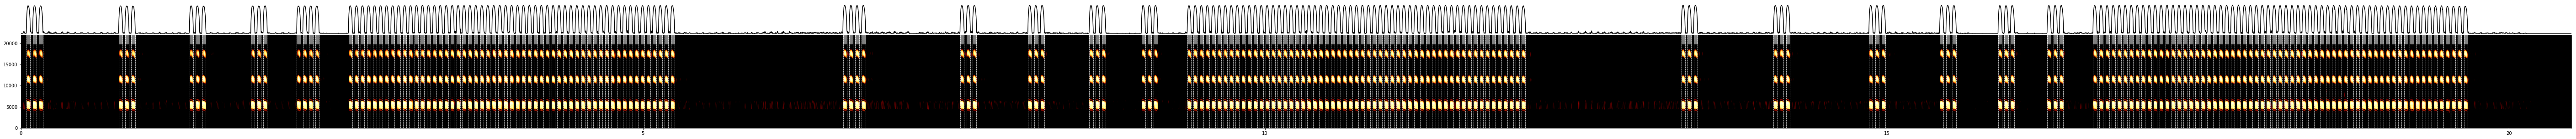

In [21]:
plot_segmentations(
    results["spec"],
    results["vocal_envelope"],
    results["onsets"],
    results["offsets"],
    hop_length_ms,
    rate,
    figsize=(100,5)
)
plt.show()

In [22]:
np.shape(results["spec"])

(337, 20501)

In [23]:
len(data)/rate / (np.shape(results["spec"])[1] / (hop_length_ms * 1000))

0.9977014560763088

In [24]:
hop_length_ms

1

### segment and plot 
- for each json, load the wav file - segment the file into start and end times
- plot the segmentation
- add to the JSON 

In [25]:
import joblib

In [26]:
from avgn.utils.json import NoIndent, NoIndentEncoder

In [27]:
warnings.filterwarnings("ignore", message = "'tqdm_notebook' object has no attribute 'sp'")

def segment_spec_custom(key, df, save=False, plot=False):
    # load wav
    rate, data = load_wav(df.data["wav_loc"])
    # filter data
    data = butter_bandpass_filter(data, butter_min, butter_max, rate)

    # segment
    results = dynamic_threshold_segmentation(
        data,
        rate,
        n_fft=n_fft,
        hop_length_ms=hop_length_ms,
        win_length_ms=win_length_ms,
        min_level_db_floor=min_level_db_floor,
        db_delta=db_delta,
        ref_level_db=ref_level_db,
        pre=pre,
        min_silence_for_spec=min_silence_for_spec,
        max_vocal_for_spec=max_vocal_for_spec,
        min_level_db=min_level_db,
        silence_threshold=silence_threshold,
        verbose=True,
        min_syllable_length_s=min_syllable_length_s,
        spectral_range=spectral_range,
    )
    if results is None:
        return
    if plot:
        plot_segmentations(
            results["spec"],
            results["vocal_envelope"],
            results["onsets"],
            results["offsets"],
            hop_length_ms,
            rate,
            figsize=(100, 5)
        )
        plt.show()

    # save the results
    json_out = DATA_DIR / "processed" / (DATASET_ID + "_segmented") / DT_ID / "JSON" / (
        key + ".JSON"
    )

    json_dict = df.data.copy()

    json_dict["indvs"][list(df.data["indvs"].keys())[0]]["syllables"] = {
        "start_times": NoIndent(list(results["onsets"])),
        "end_times": NoIndent(list(results["offsets"])),
    }

    json_txt = json.dumps(json_dict, cls=NoIndentEncoder, indent=2)
    # save json
    if save:
        ensure_dir(json_out.as_posix())
        print(json_txt, file=open(json_out.as_posix(), "w"))

    #print(json_txt)

    return results

In [28]:
indvs = np.array(['_'.join(list(i)) for i in dataset.json_indv])
np.unique(indvs)

array(['437ss', '438ss', '440ss', '441ss', '442ss', '443ss', '446ss',
       '450ss', '452ss', '453ss', '454ss', '462sl', '464sldw', '465ssdw',
       '466ssdw', '467ssdw', '468ssdw', '470ss', '475scl', '475sct',
       '479scdg', '479ss', '480ssdw1', '480ssdw2', '481ss', '482scdg',
       '483ss', '484ss', '487sl', '488ss', '489ss', '491srds', '491ss',
       '492ss', '499sl', '501ss', '521ss', '521ss2', '551ss', '575sl',
       '577sl', '581ss', '582ss', '583ss', '585ss', '585ssh', '585ssj',
       '585sso', '586ss', '587ss', '588ss', '589ss', '590ss', '591sl',
       '592ss', '593ss', '594ss', '601ss', '610ss', '611ss', '612ss',
       '613ss', '614ss', '615ss', '616ss', '617ss', '618ss', '619ss',
       '621ss', '622ss', '623ss', '624ss', '630ss', '632ss', '641ss',
       '671ss', '672ss', '679ss', '681ss', '682ss', '683ss', '684ss',
       '685ss', '686ss', 'black-horned', 'enma-koorogi', 'ezo-enma',
       'ezo-suzu', 'fall', 'fieldcricket1', 'hama-suzu', 'haraokame',
       'him

437ss


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


longest silence 0.6210000000000004
longest vocalization 0.017000000000000348


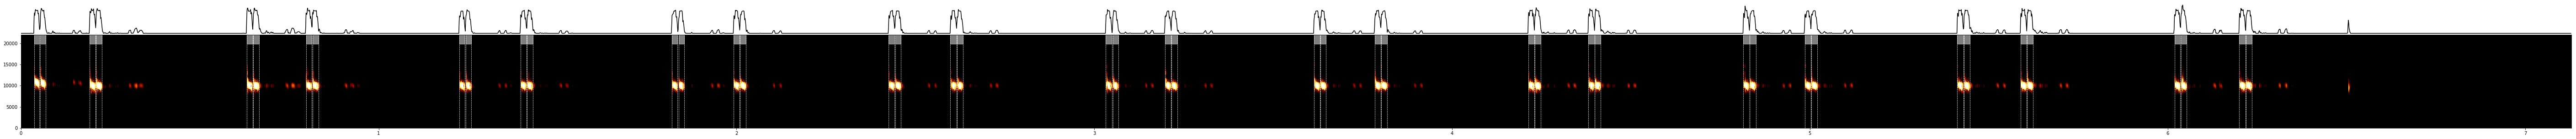

438ss


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


longest silence 2.0350000000000006
longest vocalization 0.014000000000000234


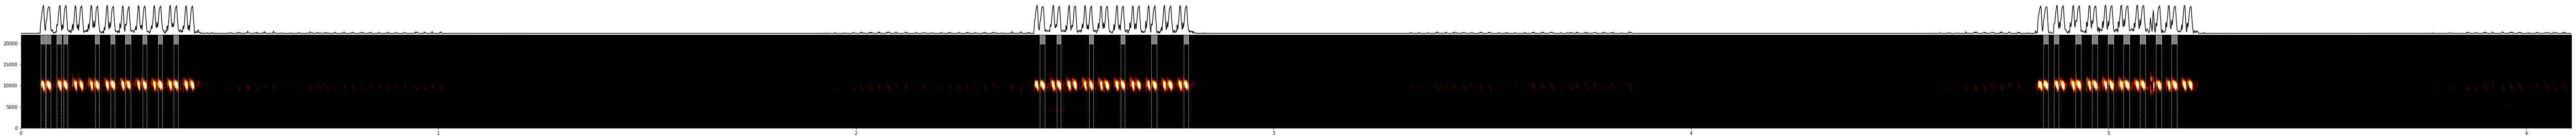

440ss


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


longest silence 1.093
longest vocalization 0.018999999999999684


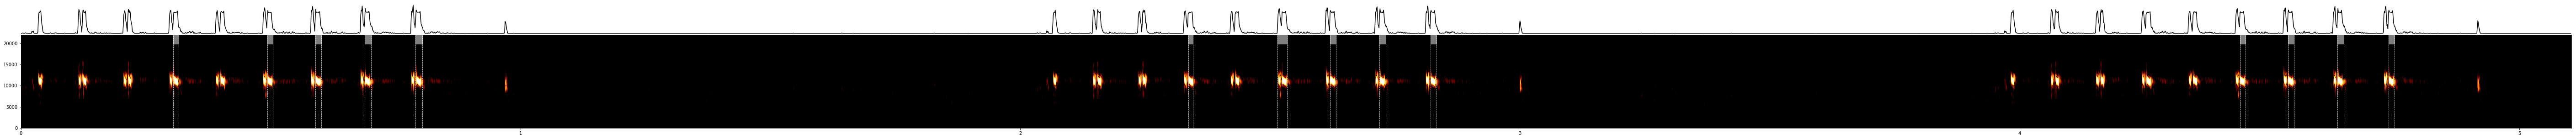

441ss


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


longest silence 1.357
longest vocalization 0.03100000000000014


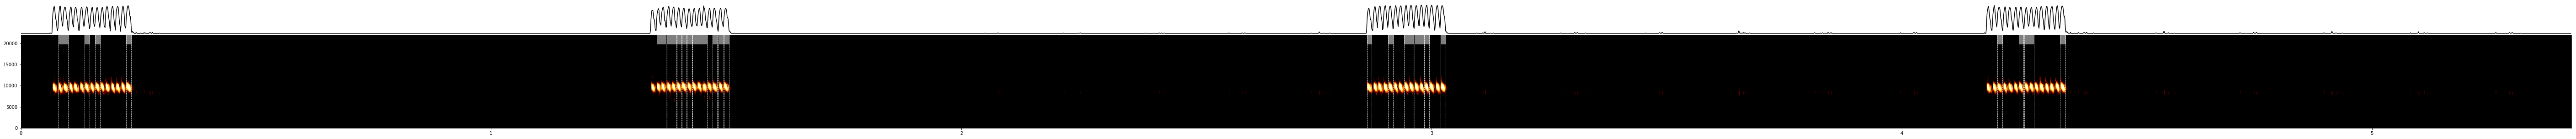

442ss


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


longest silence 1.5829999999999997
longest vocalization 0.030999999999999694


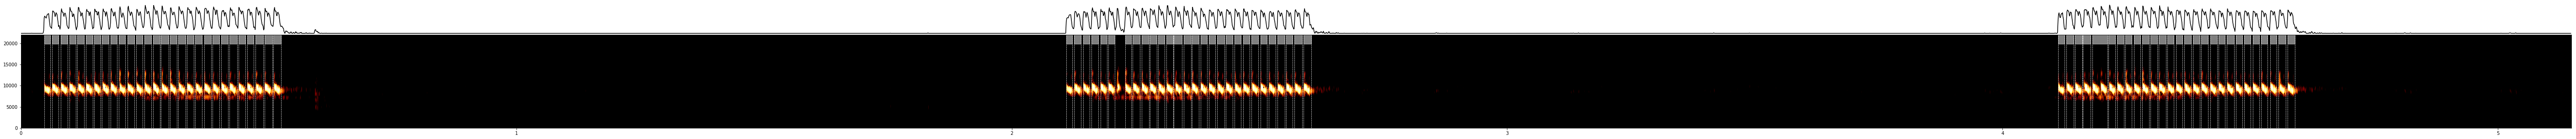

443ss


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


/mnt/cube/tsainbur/Projects/github_repos/vocalization_segmentation/vocalseg/dynamic_thresholding.py:129: RuntimeWarning: invalid value encountered in sqrt
  vocal_envelope = np.max(spec, axis=0) * np.sqrt(np.mean(spec, axis=0))


longest silence 0.9859999999999989
longest vocalization 0.016000000000000014


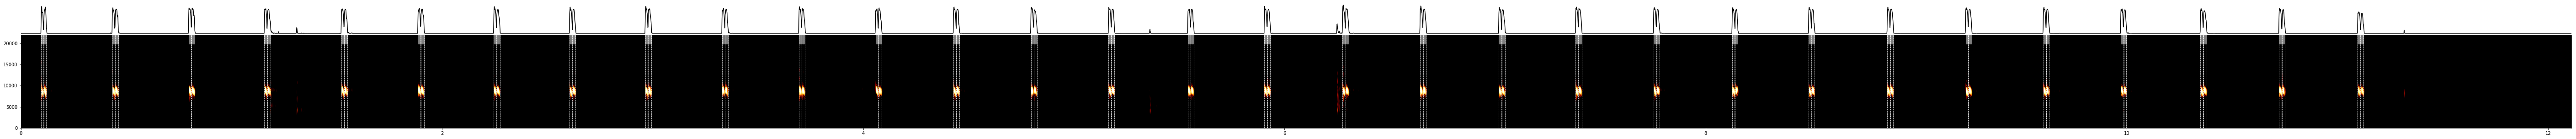

446ss


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


longest silence 2.217
longest vocalization 0.0259999999999998


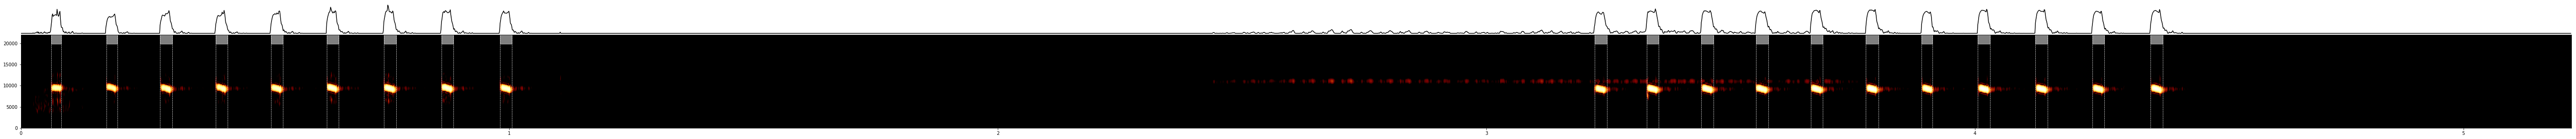

450ss


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


longest silence 0.8659999999999999
longest vocalization 0.019000000000000128


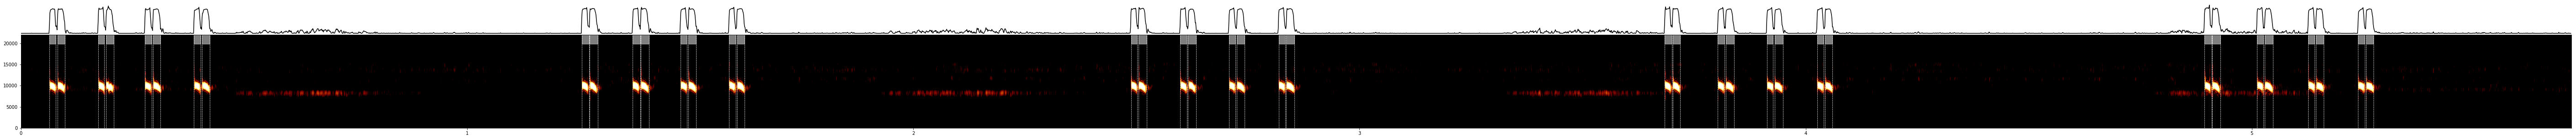

452ss


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


longest silence 0.3540000000000001
longest vocalization 0.020000000000000018


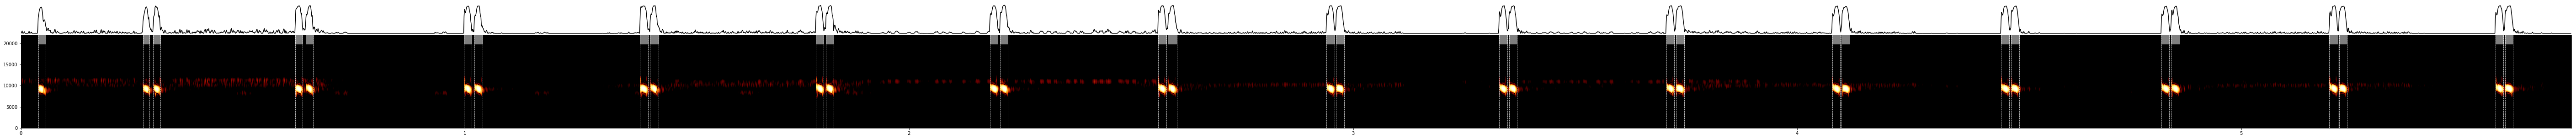

453ss


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


longest silence 0.6150000000000002
longest vocalization 0.01499999999999968


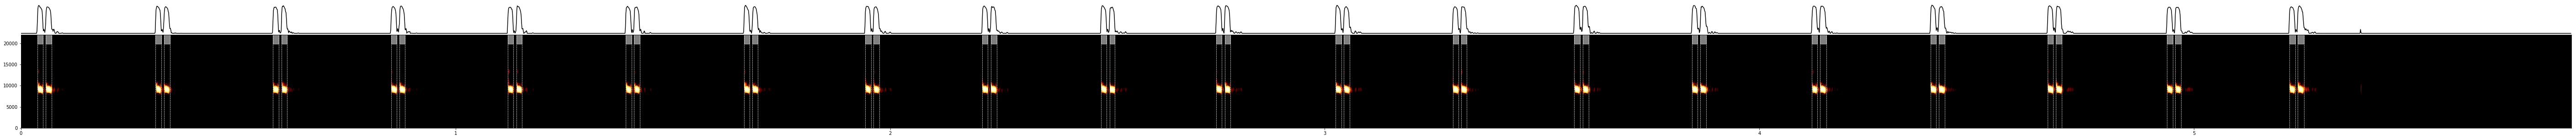

454ss


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s finished


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


longest silence 0.384
longest vocalization 0.03900000000000059


KeyboardInterrupt: 

In [29]:
nex = 3
for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv][:nex]

    joblib.Parallel(n_jobs=1, verbose=11)(
            joblib.delayed(segment_spec_custom)(key, dataset.data_files[key], plot=True) 
                 for key in tqdm(indv_keys, desc="files", leave=False)
        )

### Generate for full dataset

In [ ]:
nex = -1
for indv in tqdm(np.unique(indvs), desc="individuals"):
    print(indv)
    indv_keys = np.array(list(dataset.data_files.keys()))[indvs == indv]

    joblib.Parallel(n_jobs=-1, verbose=11)(
            joblib.delayed(segment_spec_custom)(key, dataset.data_files[key], save=True) 
                 for key in tqdm(indv_keys, desc="files", leave=False)
        )